# Dealing with data

One of the most important parts about deep learning is data. Data is pure raw information, human and machine representation of the observation of the world. Everything can be represented in data, including our literature, arts and science. In this lab, we are going to deal with data, apply some techniques to make our data ready to be applied in a machine learning model, and after that, separate our dataset in training, validation and test datasets and feed that data to a deep learning model. 

## Acquiring data

Before you can even prepare your dataset, you need to acquire one. Unless you already work in a place where you already have that data ready for you, you need to collect it yourself. There are a lot of places where you can acquire data, for example:

- [Datasets subreddit](https://www.reddit.com/r/datasets/), a community where you can share, request and discuss about datasets;

- [Kaggle](https://www.kaggle.com/), where you can search for a lot of different datasets, jupyter notebooks applying that data, and even engage in competitions;

- [Awesome datasets in Github](https://github.com/awesomedata/awesome-public-datasets), a curated list of datasets of a lot of different subjects, hosted in Github.

Sometimes, your data will not be easily available, and you will have to get your hands dirty to collect it. While it is beyond the scope of this lab, it is worth to mention that common data collection techniques involve the usage of sensors and [web-scraping](https://en.wikipedia.org/wiki/Web_scraping).


## Preprocessing the data

Let's say we downloaded the records of a HR department of a company specialized in engineering. This dataset in particular, is about the hires for a software engineering position.

In [1]:
# First, let's import our packages as usual.
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
# Then, let's load our dataset.
import os.path
path = "./Datasets/hires.csv"
if os.path.isfile(path) :
    dataset = pd.read_csv(path)
else:
    dataset = pd.read_csv("3-Feeding-your-models-with-data/" + path)

# Let's take a look at the columns we have in this dataset.
print("Dataset Columns: {}\n".format(dataset.columns.values))

Dataset Columns: ['id' 'years_of_experience' 'interview_score' 'name' 'hired']



As you can see, we have the following features:

- name: the candidate name;
- interview_score: a subjective grade that was given to the performance of the candidate in the hiring interview;
- years_of_experience: how many years this particular candidate has in the software engineering industry

And a class:

- hired: which means if the candidate ended up being hired or not;


Now, let's take a closer look at our dataset: 

In [3]:
# To see some of the data inside our dataset, simply use the dataset variable.
dataset

,id,years_of_experience,interview_score,name,hired
0,1,18,0.54,Stacia Ketchen,True
1,2,6,0.29,Maryann Rumney,False
2,3,6,NaN,Tristam Oliveti,False
3,4,2,0.51,Andrea Gianinotti,False
4,5,2,0.74,Karena Sheran,True
...,...,...,...,...,...
995,996,6,0.78,Leese Ciccoloi,True
996,997,5,0.67,Inger Ivashechkin,True
997,998,5,0.46,Jessalyn Bedingfield,False
998,999,5,0.89,Deerdre Squibe,True


There are some incomplete data inside our dataset. Incomplete data is, most of the times, bad data. So, we need to remove them.

In [4]:
import math
# Remove empty rows from dataset
for index, data in dataset.iterrows():
    if(math.isnan(data.interview_score) or math.isnan(data.years_of_experience)):
        dataset.drop(index = index, inplace = True)

# Show the updated dataset        
dataset

,id,years_of_experience,interview_score,name,hired
0,1,18,0.54,Stacia Ketchen,True
1,2,6,0.29,Maryann Rumney,False
3,4,2,0.51,Andrea Gianinotti,False
4,5,2,0.74,Karena Sheran,True
6,7,9,0.40,Rafaellle Goodbody,False
...,...,...,...,...,...
994,995,6,0.67,Alexine Bannister,True
995,996,6,0.78,Leese Ciccoloi,True
996,997,5,0.67,Inger Ivashechkin,True
997,998,5,0.46,Jessalyn Bedingfield,False


We also need to decide what features are important for the problem we are trying to solve. Deciding what features are important, is a key part of machine learning. Remember, bad data equals to bad results, and wrong features are bad data.

In this case, the interview score and the years of experience of the candidate are important features, but the name of the candidate is completely irrelevant for our model, so we can just take it out from our dataset:

In [5]:
# Delete the column name
del dataset['id']
del dataset['name']
# Show our updated dataset
dataset

,years_of_experience,interview_score,hired
0,18,0.54,True
1,6,0.29,False
3,2,0.51,False
4,2,0.74,True
6,9,0.40,False
...,...,...,...
994,6,0.67,True
995,6,0.78,True
996,5,0.67,True
997,5,0.46,False


Another thing that you should have in mind, is that "True" and "False", doesn't mean anything to a machine. We need to convert that into something that a computer will understand:

In [6]:
# Convert true to 1, and false to 0
dataset.hired = dataset.hired.astype(int)
dataset

,years_of_experience,interview_score,hired
0,18,0.54,1
1,6,0.29,0
3,2,0.51,0
4,2,0.74,1
6,9,0.40,0
...,...,...,...
994,6,0.67,1
995,6,0.78,1
996,5,0.67,1
997,5,0.46,0


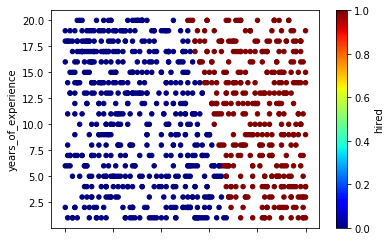

In [7]:
# Let's plot the dataset, so we can see who got hired and those who didn't.
dataset.plot(kind='scatter', x="interview_score", y="years_of_experience", c="hired", colormap='jet')

At this point, we could train our network using this dataset. But we could also improve it's representation to make it easier for the network to learn the dataset behavior. The attribute 'years_of_experience' is a value from 1 to 20 (inside our dataset). Let's normalize these values to fit between 0 and 1.

In [8]:
# Converts the dataset to numpy arrays
X = np.array(dataset[["years_of_experience","interview_score"]].astype(float))
Y = np.array(dataset[["hired"]])
Y = np.ravel(Y)

# Normalizes the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(np.array([X[:,0]]).T)
normalized = scaler.transform(np.array([X[:,0]]).T)

# Updates only the attribute "years_of_experience" with the normalized values
X[:,0] = normalized[:,0]

Now, let's separate our dataset into test and training datasets:

In [9]:
# Separate the dataset into test and training datasets
X_train, X_test, Y_train,Y_test = train_test_split(X, Y, test_size=0.25,)

Now let's build a simple classification neural network and train it:

In [10]:
def build_model():
    # Input layer
    inputs = Input([2, ], name='data')
    # Hidden layers
    model = Dense(128, activation='relu')(inputs)
    # Output layer
    outputs = Dense(1, activation='sigmoid', name='fc3')(model)

    # Define the model
    model = Model(inputs=[inputs], outputs=outputs)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

net = build_model()
print(net.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               384       
_________________________________________________________________
fc3 (Dense)                  (None, 1)                 129       
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
net.fit(X_train,
        Y_train,
        validation_data=(X_test, Y_test),
        epochs=20,
        batch_size=8)

Train on 678 samples, validate on 227 samples
Epoch 1/20
678/678 [==============================] - 0s 443us/step - loss: 0.6324 - accuracy: 0.7271 - val_loss: 0.5640 - val_accuracy: 0.8811
Epoch 2/20
678/678 [==============================] - 0s 159us/step - loss: 0.5263 - accuracy: 0.8363 - val_loss: 0.4397 - val_accuracy: 0.9119
Epoch 3/20
678/678 [==============================] - 0s 163us/step - loss: 0.4206 - accuracy: 0.8820 - val_loss: 0.3322 - val_accuracy: 0.9383
Epoch 4/20
678/678 [==============================] - 0s 160us/step - loss: 0.3314 - accuracy: 0.9218 - val_loss: 0.2611 - val_accuracy: 0.9604
Epoch 5/20
678/678 [==============================] - 0s 165us/step - loss: 0.2692 - accuracy: 0.9425 - val_loss: 0.2061 - val_accuracy: 0.9824
Epoch 6/20
678/678 [==============================] - 0s 162us/step - loss: 0.2235 - accuracy: 0.9587 - val_loss: 0.1678 - val_accuracy: 0.9824
Epoch 7/20
678/678 [==============================] - 0s 165us/step - loss: 0.1898 - accur

In [12]:
# Print model performance
test_loss, test_acc = net.evaluate(X_test,  Y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# Predict if a new candidate with interview score of 0.6 and 15 years of experience will be hired
input = np.array([[15,0.6]])
prediction = net.predict(input)
for index, predict in enumerate(prediction):
    print("Candidate has {:.2f}% chance to be hired".format(predict[0]*100))


Test accuracy: 0.9867841601371765
Candidate has 100.00% chance to be hired


We can generate a map covering all the possible predictions to see how our model behaves

Remember that years_of_experience was normalized, so 0 and 1 respectively represent 1.0 and 20.0.


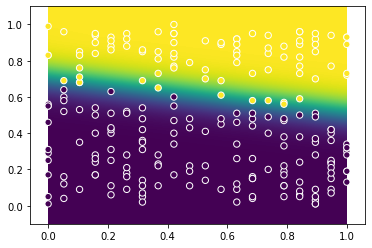

In [13]:
# Generate a classification map
N = 60

years_range = (X[:,0].min(), X[:,0].max())
scores_range = (X[:,1].min()-.1, X[:,1].max()+.1)

linear_years = np.linspace(years_range[0], years_range[1], N)
linear_scores = np.linspace(scores_range[0], scores_range[1], N)

prediction_map = np.array([net.predict(np.array([[i,j]])) for j in linear_scores for i in linear_years]).reshape(N, N)

years_range_unscale = scaler.inverse_transform(np.array([years_range]))
print("Remember that years_of_experience was normalized, so 0 and 1 respectively represent {0} and {1}."
      .format(years_range_unscale[0,0], years_range_unscale[0,1]))

# Plots our test dataset on top of our prediction map
plt.imshow(prediction_map,
           interpolation='bilinear',
           extent=[
               years_range[0], years_range[1], scores_range[0], scores_range[1]
           ],
           aspect='auto' , origin='lower')
plt.scatter(np.array(X_test)[:,0], np.array(X_test)[:,1], 40, Y_test, edgecolors='w')
plt.show()